In [1]:
import random
import pickle
import pandas as pd
import numpy as np
import Identify
from tensorflow import keras
from Bio import SeqIO

# Human

## Linc2Function

In [2]:
hs_column_names = ['ORF_LENGTH', 'UTR5_GC_CONTENT', 'HEXAMER_BIAS', 'CODON_BIAS', 'FICKETT_A_POS', 'FICKETT_G_POS', 'FICKETT_T_POS', 'DFT_MAX', 'SNR', 'QNT_3', 'TARGET']
sa_column_names = ['ORF_LENGTH', 'UTR5_GC_CONTENT', 'FICKETT_A_POS', 'FICKETT_G_POS', 'FICKETT_T_POS', 'FICKETT_BASE_RATIO_2', 'FICKETT_BASE_RATIO_4', 'SNR', 'QNT_2', 'QNT_3', 'TARGET']

In [3]:
hs_model = keras.models.load_model('models/ann_1_model_hs.h5')
sa_model = keras.models.load_model('models/ann_1_model_sa.h5')

In [4]:
hs_scaler = pickle.load(open('scalers/scaler_hs.pkl','rb'))
sa_scaler = pickle.load(open('scalers/scaler_sa.pkl','rb'))

In [5]:
coding_seq_list = []
noncoding_seq_list = []
hs_features_list = []
sa_features_list = []

for record in SeqIO.parse('data/gencode.v34.pc_transcripts.fa', "fasta"):
    sequence = str(record.seq)
    coding_seq_list.append(sequence)

random.seed(21)
sampled_coding_seq_list = random.sample(coding_seq_list, 10000)

for sequence in sampled_coding_seq_list:
    hs_features = Identify.extractHSFeatures(sequence)
    hs_features.append(0)
    sa_features = Identify.extractSAFeatures(sequence)
    sa_features.append(0)
    hs_features_list.append(hs_features)
    sa_features_list.append(sa_features)

for record in SeqIO.parse('data/gencode.v34.lncRNA_transcripts.fa', "fasta"):
    sequence = str(record.seq)
    noncoding_seq_list.append(sequence)

random.seed(21)
sampled_noncoding_seq_list = random.sample(noncoding_seq_list, 10000)

for sequence in sampled_noncoding_seq_list:
    hs_features = Identify.extractHSFeatures(sequence)
    hs_features.append(1)
    sa_features = Identify.extractSAFeatures(sequence)
    sa_features.append(1)
    hs_features_list.append(hs_features)
    sa_features_list.append(sa_features)


In [6]:
hs_df = pd.DataFrame(hs_features_list, columns = hs_column_names)
sa_df = pd.DataFrame(sa_features_list, columns = sa_column_names)

In [7]:
X_hs_df = hs_df[hs_df.columns[~hs_df.columns.isin(['TARGET'])]]
y_hs_df = hs_df['TARGET']

X_sa_df = sa_df[sa_df.columns[~sa_df.columns.isin(['TARGET'])]]
y_sa_df = sa_df['TARGET']

In [8]:
hs_df_scaled = hs_scaler.transform(X_hs_df.astype(np.float64))
sa_df_scaled = sa_scaler.transform(X_sa_df.astype(np.float64))

In [9]:
hs_preds = hs_model.predict(hs_df_scaled)
sa_preds = sa_model.predict(sa_df_scaled)

hs_preds_classes = hs_model.predict_classes(hs_df_scaled)
sa_preds_classes = sa_model.predict_classes(sa_df_scaled)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


## LncADeep

In [10]:
index = 0
results = []
with open('/home/monash/minor_thesis/workspace/LncADeep/coding_LncADeep_lncRNA_results/coding_LncADeep.results', 'r') as lncadeep_coding_results_file:
    while True:
        index += 1
        result = lncadeep_coding_results_file.readline()
        if index == 1:
            continue
        if not result:
            break
        results.append(result.strip().split('\t') + [0])
lncadeep_coding_results_df = pd.DataFrame(results, columns=['Transcript_ID', 'MajorityVoteNum', 'Index', '1_ModelScores', '2_ModelScores', '3_ModelScores', '4_ModelScores', '5_ModelScores', '6_ModelScores', '7_ModelScores', '8_ModelScores', '9_ModelScores', '10_ModelScores', '11_ModelScores', '12_ModelScores', '13_ModelScores', '14_ModelScores', '15_ModelScores', '16_ModelScores', '17_ModelScores', '18_ModelScores', '19_ModelScores', '20_ModelScores', '21_ModelScores', 'TARGET'])
lncadeep_coding_results_df.head()

Transcript_ID MajorityVoteNum  \
0  ENST00000264748.6|ENSG00000127418.15|OTTHUMG00...              21   
1  ENST00000533971.2|ENSG00000109846.9|OTTHUMG000...              21   
2  ENST00000597597.1|ENSG00000167766.18|OTTHUMG00...              21   
3  ENST00000534100.1|ENSG00000254445.1|OTTHUMG000...              21   
4  ENST00000589194.5|ENSG00000184828.10|OTTHUMG00...               0   

       Index         1_ModelScores         2_ModelScores        3_ModelScores  \
0     Coding    0.9715875969608538    0.9977740775883169   0.9946739995336746   
1     Coding    0.9124527914710282    0.9753734300266619   0.9190415212879933   
2     Coding    0.7185036393114921    0.9891273918723147   0.9909950115515688   
3     Coding    0.8478025600276644    0.9853728596763552   0.9718898240316072   
4  Noncoding  0.040600015445049036  0.052164147041619265  0.04431393580560856   

        4_ModelScores         5_ModelScores        6_ModelScores  \
0  0.9949214156691462    0.9947904118209006   0.9946158402041391   
1  0.9892560706815458      0.98163100169242   0.9675527502549635   
2   0.987351139512211     0.993289713100428   0.9948582104708048   
3  0.9135572794182898    0.9458952946379036   0.9507844816744135   
4  0.0688448889616427  0.024487200514572535  0.04091826522637674   

         7_ModelScores  ...       13_ModelScores        14_ModelScores  \
0    0.995450060806792  ...   0.9973335308513224    0.9738199774770291   
1   0.9513680354621236  ...    0.993042402745529     0.911838528271778   
2   0.9902987060217854  ...   0.9965689556616827    0.8877416433387632   
3   0.9877672129520858  ...   0.9799451064927182    0.7755117136392388   
4  0.05931642333976435  ...  0.04394651534775358  0.038152752388467465   

        15_ModelScores       16_ModelScores       17_ModelScores  \
0   0.9856249426933584   0.9864789923244063   0.9953974565584689   
1   0.9658629701683936   0.9721417723978089   0.9689774839895464   
2   0.8661211172699568    0.965357245841196   0.9337681373124895   
3    0.933744647599942   0.9195601733533803   0.9611205937438099   
4  0.04477284031077456  0.07795691268545735  0.06373055326893118   

        18_ModelScores       19_ModelScores        20_ModelScores  \
0   0.9928927620685355   0.9939461876054577    0.9954166097025843   
1   0.9880127149350947   0.9746792982706196    0.9781512288375082   
2   0.9610547070171923   0.9924369419710218    0.9922556327319304   
3   0.9654013275176808   0.9654458166526563    0.9075718536245398   
4  0.04384648600544116  0.10494009323245576  0.058188094365457695   

        21_ModelScores TARGET  
0   0.9931760590870261      0  
1   0.9711551151248939      0  
2   0.9833504142515566      0  
3   0.9084080483667709      0  
4  0.08343885961056147      0  

[5 rows x 25 columns]

In [11]:
index = 0
results = []
with open('/home/monash/minor_thesis/workspace/LncADeep/noncoding_LncADeep_lncRNA_results/noncoding_LncADeep.results', 'r') as lncadeep_noncoding_results_file:
    while True:
        index += 1
        result = lncadeep_noncoding_results_file.readline()
        if index == 1:
            continue
        if not result:
            break
        results.append(result.strip().split('\t') + [1])
lncadeep_noncoding_results_df = pd.DataFrame(results, columns=['Transcript_ID', 'MajorityVoteNum', 'Index', '1_ModelScores', '2_ModelScores', '3_ModelScores', '4_ModelScores', '5_ModelScores', '6_ModelScores', '7_ModelScores', '8_ModelScores', '9_ModelScores', '10_ModelScores', '11_ModelScores', '12_ModelScores', '13_ModelScores', '14_ModelScores', '15_ModelScores', '16_ModelScores', '17_ModelScores', '18_ModelScores', '19_ModelScores', '20_ModelScores', '21_ModelScores', 'TARGET'])
lncadeep_noncoding_results_df.head()

Transcript_ID MajorityVoteNum  \
0  ENST00000661576.1|ENSG00000287941.1|OTTHUMG000...               0   
1  ENST00000532430.1|ENSG00000254443.1|OTTHUMG000...               0   
2  ENST00000530479.1|ENSG00000254419.1|OTTHUMG000...               0   
3  ENST00000527398.1|ENSG00000254641.1|OTTHUMG000...               0   
4  ENST00000657832.1|ENSG00000267013.6|OTTHUMG000...               0   

       Index         1_ModelScores        2_ModelScores         3_ModelScores  \
0  Noncoding   0.28128106005738845  0.06674076926969039   0.08376539419549155   
1  Noncoding   0.04648370172148793  0.04957061059421442  0.025169214825344507   
2  Noncoding   0.12231502261084136  0.08239491388528523   0.10223647168409629   
3  Noncoding   0.07687114071948711   0.0648306621981052   0.05200141061804354   
4  Noncoding  0.018668435618810094  0.01603274371806404  0.021290156561169487   

          4_ModelScores         5_ModelScores         6_ModelScores  \
0   0.10388810611078042  0.029198017307050156   0.27799009310965783   
1   0.02334139550593906   0.05445730598676924  0.023348887426755807   
2  0.049756120332413764   0.07996825261248083   0.03570651265124422   
3    0.0357116857914829   0.08523511016539143  0.030703227885219352   
4  0.013993981768538324    0.0109558725334622  0.013535171757687594   

          7_ModelScores  ...        13_ModelScores        14_ModelScores  \
0   0.09567127132294526  ...  0.006295040473478156   0.13296259222519619   
1  0.011882593602476463  ...  0.010575902700715503   0.03609623555544529   
2   0.23026237141170486  ...   0.03321233365293693    0.1297233948446046   
3  0.032183699899761026  ...  0.023051330670416096   0.08574293330380452   
4  0.008742267541215926  ...  0.002754932210448477  0.017069186653725255   

         15_ModelScores       16_ModelScores        17_ModelScores  \
0   0.13277712409675482  0.08814114292587652   0.19367421635301588   
1   0.03915157261348427  0.03232811306733013   0.03346281272218961   
2   0.16416590460064673  0.07089792471344337   0.12300552555327793   
3  0.054957274259793666  0.06428958946069611   0.05482369759725003   
4  0.017667364034712037  0.01861774091052929  0.015228839600383624   

         18_ModelScores        19_ModelScores        20_ModelScores  \
0   0.15318924354067293   0.16523516759010876   0.10675148786113334   
1  0.028055460580298574   0.03708849019012363  0.028084534534491536   
2   0.08304886723258963    0.1568417843447415   0.06826878246568734   
3   0.04739534726495806   0.03916789337128654   0.06602456345586744   
4   0.01812750714930762  0.022579731610187833  0.013131551612499548   

         21_ModelScores TARGET  
0   0.05089425441121948      1  
1  0.023179486619163886      1  
2   0.05222004354001912      1  
3  0.055355404405612804      1  
4  0.022183246071388524      1  

[5 rows x 25 columns]

In [12]:
lncadeep_results_df = pd.concat([lncadeep_noncoding_results_df, lncadeep_coding_results_df])
lncadeep_results_df.shape

(20000, 25)

In [13]:
for column in lncadeep_results_df.columns:
    if column.endswith('ModelScores'):
        lncadeep_results_df[column] = lncadeep_results_df[column].astype(float)

lncadeep_results_df['Index'] = [1 if value == 'Noncoding' else 0 for value in lncadeep_results_df['Index']]

lncadeep_results_df['AverageScore'] = lncadeep_results_df[['1_ModelScores', '2_ModelScores', '3_ModelScores', '4_ModelScores', '5_ModelScores', '6_ModelScores', '7_ModelScores', '8_ModelScores', '9_ModelScores', '10_ModelScores', '11_ModelScores', '12_ModelScores', '13_ModelScores', '14_ModelScores', '15_ModelScores', '16_ModelScores', '17_ModelScores', '18_ModelScores', '19_ModelScores', '20_ModelScores', '21_ModelScores']].mean(axis=1)

lncadeep_results_df['AverageScore'] = [1 - value for value in lncadeep_results_df['AverageScore']]

lncadeep_results_df.head()

Transcript_ID MajorityVoteNum  Index  \
0  ENST00000661576.1|ENSG00000287941.1|OTTHUMG000...               0      1   
1  ENST00000532430.1|ENSG00000254443.1|OTTHUMG000...               0      1   
2  ENST00000530479.1|ENSG00000254419.1|OTTHUMG000...               0      1   
3  ENST00000527398.1|ENSG00000254641.1|OTTHUMG000...               0      1   
4  ENST00000657832.1|ENSG00000267013.6|OTTHUMG000...               0      1   

   1_ModelScores  2_ModelScores  3_ModelScores  4_ModelScores  5_ModelScores  \
0       0.281281       0.066741       0.083765       0.103888       0.029198   
1       0.046484       0.049571       0.025169       0.023341       0.054457   
2       0.122315       0.082395       0.102236       0.049756       0.079968   
3       0.076871       0.064831       0.052001       0.035712       0.085235   
4       0.018668       0.016033       0.021290       0.013994       0.010956   

   6_ModelScores  7_ModelScores  ...  14_ModelScores  15_ModelScores  \
0       0.277990       0.095671  ...        0.132963        0.132777   
1       0.023349       0.011883  ...        0.036096        0.039152   
2       0.035707       0.230262  ...        0.129723        0.164166   
3       0.030703       0.032184  ...        0.085743        0.054957   
4       0.013535       0.008742  ...        0.017069        0.017667   

   16_ModelScores  17_ModelScores  18_ModelScores  19_ModelScores  \
0        0.088141        0.193674        0.153189        0.165235   
1        0.032328        0.033463        0.028055        0.037088   
2        0.070898        0.123006        0.083049        0.156842   
3        0.064290        0.054824        0.047395        0.039168   
4        0.018618        0.015229        0.018128        0.022580   

   20_ModelScores  21_ModelScores  TARGET  AverageScore  
0        0.106751        0.050894       1      0.887319  
1        0.028085        0.023179       1      0.970222  
2        0.068269        0.052220       1      0.908133  
3        0.066025        0.055355       1      0.949107  
4        0.013132        0.022183       1      0.985522  

[5 rows x 26 columns]

## LncRNAnet

In [14]:
lncrnanet_coding_results_df = pd.read_csv('/home/monash/minor_thesis/workspace/lncRNAnet/data/benchmark/benchmark_coding.txt', sep='\t', header=None)
lncrnanet_coding_results_df.columns = ['TranscriptId', 'TranscriptLength', 'Score']
lncrnanet_coding_results_df['TARGET'] = [0] * lncrnanet_coding_results_df.shape[0]
lncrnanet_coding_results_df['PREDICTION'] = [0 if score < 0 else 1 for score in lncrnanet_coding_results_df.Score]
lncrnanet_coding_results_df.head()

TranscriptId  TranscriptLength  \
0  ENST00000264748.6|ENSG00000127418.15|OTTHUMG00...              3100   
1  ENST00000533971.2|ENSG00000109846.9|OTTHUMG000...              2271   
2  ENST00000597597.1|ENSG00000167766.18|OTTHUMG00...              4442   
3  ENST00000534100.1|ENSG00000254445.1|OTTHUMG000...              1521   
4  ENST00000589194.5|ENSG00000184828.10|OTTHUMG00...               725   

      Score  TARGET  PREDICTION  
0 -0.996835       0           0  
1 -0.093217       0           0  
2 -0.999049       0           0  
3  0.589708       0           1  
4 -0.309586       0           0

In [15]:
lncrnanet_noncoding_results_df = pd.read_csv('/home/monash/minor_thesis/workspace/lncRNAnet/data/benchmark/benchmark_noncoding.txt', sep='\t', header=None)
lncrnanet_noncoding_results_df.columns = ['TranscriptId', 'TranscriptLength', 'Score']
lncrnanet_noncoding_results_df['TARGET'] = [1] * lncrnanet_noncoding_results_df.shape[0]
lncrnanet_noncoding_results_df['PREDICTION'] = [0 if score < 0 else 1 for score in lncrnanet_noncoding_results_df.Score]
lncrnanet_noncoding_results_df.head()

TranscriptId  TranscriptLength  \
0  ENST00000661576.1|ENSG00000287941.1|OTTHUMG000...               721   
1  ENST00000532430.1|ENSG00000254443.1|OTTHUMG000...              1288   
2  ENST00000530479.1|ENSG00000254419.1|OTTHUMG000...               577   
3  ENST00000527398.1|ENSG00000254641.1|OTTHUMG000...               429   
4  ENST00000657832.1|ENSG00000267013.6|OTTHUMG000...               948   

      Score  TARGET  PREDICTION  
0  0.377858       1           1  
1  0.993531       1           1  
2  0.839105       1           1  
3  0.780423       1           1  
4  0.951318       1           1

In [16]:
lncrnanet_results_df = pd.concat([lncrnanet_noncoding_results_df, lncrnanet_coding_results_df])
lncrnanet_results_df.shape

(20000, 5)

## Results

In [17]:
from sklearn.metrics import auc, accuracy_score, accuracy_score, balanced_accuracy_score
from sklearn.metrics import roc_curve

fpr_hs, tpr_hs, _ = roc_curve(y_hs_df, hs_preds)
fpr_sa, tpr_sa, _ = roc_curve(y_sa_df, sa_preds)
fpr_ld, tpr_ld, _ = roc_curve(lncadeep_results_df.TARGET, lncadeep_results_df.AverageScore)
fpr_lrn, tpr_lrn, _ = roc_curve(lncrnanet_results_df.TARGET, lncrnanet_results_df.Score)
auc_hs = auc(fpr_hs, tpr_hs)
auc_sa = auc(fpr_sa, tpr_sa)
auc_ld = auc(fpr_ld, tpr_ld)
auc_lrn = auc(fpr_lrn, tpr_lrn)
accuracy_score_hs = accuracy_score(y_hs_df, hs_preds_classes)
accuracy_score_sa = accuracy_score(y_sa_df, sa_preds_classes)
accuracy_score_ld = accuracy_score(lncadeep_results_df.TARGET, lncadeep_results_df.Index)
accuracy_score_lrn = accuracy_score(lncrnanet_results_df.TARGET, lncrnanet_results_df.PREDICTION)
balanced_accuracy_score_hs = balanced_accuracy_score(y_hs_df, hs_preds_classes)
balanced_accuracy_score_sa = balanced_accuracy_score(y_sa_df, sa_preds_classes)
balanced_accuracy_score_ld = balanced_accuracy_score(lncadeep_results_df.TARGET, lncadeep_results_df.Index)
balanced_accuracy_score_lrn = balanced_accuracy_score(lncrnanet_results_df.TARGET, lncrnanet_results_df.PREDICTION)
print("AUC for Linc2Function Human Specific Model: ", auc_hs)
print("AUC for Linc2Function Species Agnostic Model: ", auc_sa)
print("AUC for LncADeep Model: ", auc_ld)
print("AUC for LncRNAnet Model: ", auc_lrn)
print("Accuracy Score for Linc2Function Human Specific Model: ", accuracy_score_hs)
print("Accuracy Score for Linc2Function Species Agnostic Model: ", accuracy_score_sa)
print("Accuracy Score for LncADeep Model: ", accuracy_score_ld)
print("Accuracy Score for LncRNAnet Model: ", accuracy_score_lrn)
print("Balanced Accuracy Score for Linc2Function Human Specific Model: ", balanced_accuracy_score_hs)
print("Balanced Accuracy Score for Linc2Function Species Agnostic Model: ", balanced_accuracy_score_sa)
print("Balanced Accuracy Score for LncADeep Model: ", balanced_accuracy_score_ld)
print("Balanced Accuracy Score for LncRNAnet Model: ", balanced_accuracy_score_lrn)

AUC for Linc2Function Human Specific Model:  0.9461446499999999
AUC for Linc2Function Species Agnostic Model:  0.9364212099999998
AUC for LncADeep Model:  0.9874361199999999
AUC for LncRNAnet Model:  0.980029
Accuracy Score for Linc2Function Human Specific Model:  0.88255
Accuracy Score for Linc2Function Species Agnostic Model:  0.8702
Accuracy Score for LncADeep Model:  0.9581
Accuracy Score for LncRNAnet Model:  0.9427
Balanced Accuracy Score for Linc2Function Human Specific Model:  0.88255
Balanced Accuracy Score for Linc2Function Species Agnostic Model:  0.8702
Balanced Accuracy Score for LncADeep Model:  0.9581
Balanced Accuracy Score for LncRNAnet Model:  0.9427


In [18]:
from sklearn.metrics import classification_report
target_names = ['coding', 'noncoding']
print('Classification Report for Linc2Function Human Specific Model: ')
print(classification_report(y_hs_df, hs_preds_classes, target_names=target_names))
print('Classification Report for Linc2Function Species Agnostic Model: ')
print(classification_report(y_sa_df, sa_preds_classes, target_names=target_names))
print('Classification Report for LncADeep Model: ')
print(classification_report(lncadeep_results_df.TARGET, lncadeep_results_df.Index, target_names=target_names))
print('Classification Report for LncRNAnet Model: ')
print(classification_report(lncrnanet_results_df.TARGET, lncrnanet_results_df.PREDICTION, target_names=target_names))

Classification Report for Linc2Function Human Specific Model: 
              precision    recall  f1-score   support

      coding       0.89      0.88      0.88     10000
   noncoding       0.88      0.89      0.88     10000

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000

Classification Report for Linc2Function Species Agnostic Model: 
              precision    recall  f1-score   support

      coding       0.87      0.87      0.87     10000
   noncoding       0.87      0.87      0.87     10000

    accuracy                           0.87     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000

Classification Report for LncADeep Model: 
              precision    recall  f1-score   support

      coding       0.98      0.94      0.96     10000
   noncoding       0.94      0.98      0.96     10000

    accurac

In [19]:
from sklearn.metrics import confusion_matrix

print('Confusion Matrix for Linc2Function Human Specific Model: ')
confusion_matrix_hs = confusion_matrix(y_hs_df, hs_preds_classes)
print(confusion_matrix_hs)
print('Confusion Matrix for Linc2Function Species Agnostic Model: ')
confusion_matrix_sa = confusion_matrix(y_sa_df, sa_preds_classes)
print(confusion_matrix_sa)
print('Confusion Matrix for LncADeep Model: ')
confusion_matrix_ld = confusion_matrix(lncadeep_results_df.TARGET, lncadeep_results_df.Index)
print(confusion_matrix_ld)
print('Confusion Matrix for LncRNAnet Model: ')
confusion_matrix_lrn = confusion_matrix(lncrnanet_results_df.TARGET, lncrnanet_results_df.PREDICTION)
print(confusion_matrix_lrn)

Confusion Matrix for Linc2Function Human Specific Model: 
[[8774 1226]
 [1123 8877]]
Confusion Matrix for Linc2Function Species Agnostic Model: 
[[8721 1279]
 [1317 8683]]
Confusion Matrix for LncADeep Model: 
[[9396  604]
 [ 234 9766]]
Confusion Matrix for LncRNAnet Model: 
[[9116  884]
 [ 262 9738]]


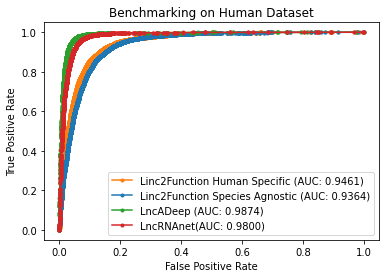

In [20]:
from matplotlib import pyplot

fpr_hs, tpr_hs, _ = roc_curve(y_hs_df, hs_preds)
fpr_sa, tpr_sa, _ = roc_curve(y_sa_df, sa_preds)
fpr_ld, tpr_ld, _ = roc_curve(lncadeep_results_df.TARGET, lncadeep_results_df.AverageScore)
fpr_lrn, tpr_lrn, _ = roc_curve(lncrnanet_results_df.TARGET, lncrnanet_results_df.Score)
pyplot.plot(fpr_hs, tpr_hs, marker='.', color='tab:orange', label='Linc2Function Human Specific (AUC: 0.9461)')
pyplot.plot(fpr_sa, tpr_sa, marker='.', color='tab:blue', label='Linc2Function Species Agnostic (AUC: 0.9364)')
pyplot.plot(fpr_ld, tpr_ld, marker='.', color='tab:green', label='LncADeep (AUC: 0.9874)')
pyplot.plot(fpr_lrn, tpr_lrn, marker='.', color='tab:red', label='LncRNAnet(AUC: 0.9800)')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.title('Benchmarking on Human Dataset')
pyplot.show()

# Zebrafish

## Linc2Function

In [21]:
import random 

coding_seq_list = []
noncoding_seq_list = []
hs_features_list = []
sa_features_list = []

for record in SeqIO.parse('data/Danio_rerio.GRCz11.cds.all.fa', "fasta"):
    sequence = str(record.seq)
    if 'N' not in sequence:
        coding_seq_list.append(sequence)

print('Coding sequences collected: ' + str(len(coding_seq_list)))
random.seed(123)
sampled_coding_seq_list = random.sample(coding_seq_list, 8000)

for sequence in sampled_coding_seq_list:
    hs_features = Identify.extractHSFeatures(sequence)
    hs_features.append(0)
    sa_features = Identify.extractSAFeatures(sequence)
    sa_features.append(0)
    hs_features_list.append(hs_features)
    sa_features_list.append(sa_features)

for record in SeqIO.parse('data/Danio_rerio.GRCz11.ncrna.fa', "fasta"):
    sequence = str(record.seq)
    if 'N' not in sequence:
        noncoding_seq_list.append(sequence)

print('Noncoding sequences collected: ' + str(len(noncoding_seq_list)))
random.seed(123)
sampled_noncoding_seq_list = random.sample(noncoding_seq_list, 8000)

for sequence in sampled_noncoding_seq_list:
    hs_features = Identify.extractHSFeatures(sequence)
    hs_features.append(1)
    sa_features = Identify.extractSAFeatures(sequence)
    sa_features.append(1)
    hs_features_list.append(hs_features)
    sa_features_list.append(sa_features)

Coding sequences collected: 49087
Noncoding sequences collected: 8074


In [22]:
hs_df = pd.DataFrame(hs_features_list, columns = hs_column_names)
sa_df = pd.DataFrame(sa_features_list, columns = sa_column_names)

In [23]:
X_hs_df = hs_df[hs_df.columns[~hs_df.columns.isin(['TARGET'])]]
y_hs_df = hs_df['TARGET']

X_sa_df = sa_df[sa_df.columns[~sa_df.columns.isin(['TARGET'])]]
y_sa_df = sa_df['TARGET']

In [24]:
hs_df_scaled = hs_scaler.transform(X_hs_df.astype(np.float64))
sa_df_scaled = sa_scaler.transform(X_sa_df.astype(np.float64))

In [25]:
hs_preds = hs_model.predict(hs_df_scaled)
sa_preds = sa_model.predict(sa_df_scaled)

hs_preds_classes = hs_model.predict_classes(hs_df_scaled)
sa_preds_classes = sa_model.predict_classes(sa_df_scaled)

## LncADeep

In [26]:
index = 0
results = []
with open('/home/monash/minor_thesis/workspace/LncADeep/zebrafish_noncoding_LncADeep_lncRNA_results/zebrafish_noncoding_LncADeep.results', 'r') as lncadeep_noncoding_results_file:
    while True:
        index += 1
        result = lncadeep_noncoding_results_file.readline()
        if index == 1:
            continue
        if not result:
            break
        results.append(result.strip().split('\t') + [1])
lncadeep_noncoding_results_df = pd.DataFrame(results, columns=['Transcript_ID', 'MajorityVoteNum', 'Index', '1_ModelScores', '2_ModelScores', '3_ModelScores', '4_ModelScores', '5_ModelScores', '6_ModelScores', '7_ModelScores', '8_ModelScores', '9_ModelScores', '10_ModelScores', '11_ModelScores', '12_ModelScores', '13_ModelScores', '14_ModelScores', '15_ModelScores', '16_ModelScores', '17_ModelScores', '18_ModelScores', '19_ModelScores', '20_ModelScores', '21_ModelScores', 'TARGET'])
lncadeep_noncoding_results_df.head()


Transcript_ID MajorityVoteNum      Index        1_ModelScores  \
0  ENSDART00000168794.2               1  Noncoding   0.1304655130745347   
1  ENSDART00000153014.2               0  Noncoding  0.18397708836148866   
2  ENSDART00000138564.2              12     Coding    0.910809221568797   
3  ENSDART00000185045.1               0  Noncoding   0.1772520311711544   
4  ENSDART00000194760.1              21     Coding   0.9971098649619308   

          2_ModelScores         3_ModelScores        4_ModelScores  \
0   0.19573512085692746  0.020942026046518018  0.10036066136397617   
1   0.10255436605955968   0.04211291908348421  0.08001968545860168   
2   0.23097177570427382    0.6191227930859915   0.8470712411827694   
3  0.033348710262830525   0.04052088595174551   0.1507988019759904   
4    0.9962879253663764     0.995737442974253   0.9955334432037154   

          5_ModelScores         6_ModelScores        7_ModelScores  ...  \
0  0.021121372267261535   0.02678887365933552   0.5357615132448086  ...   
1   0.05125710220045318  0.028861321126096358  0.13064680607657836  ...   
2   0.24182307500054986   0.43498409105475205  0.21020542991697844  ...   
3   0.23848463074695664  0.017906670413229235  0.05509269317571173  ...   
4    0.9969086833665575     0.995339293395288   0.9946679680815905  ...   

         13_ModelScores        14_ModelScores       15_ModelScores  \
0   0.01799309929322981   0.23379102414949593   0.3261561137566652   
1  0.025140274266102602     0.195859235741883  0.22719798314306272   
2    0.2531314418290055    0.7692802087265276   0.8539445355087192   
3   0.03591422569772464  0.061603032031231394  0.07623720760814232   
4    0.9958599984045883    0.9972792985702463   0.9975956508392197   

         16_ModelScores       17_ModelScores       18_ModelScores  \
0    0.3481845532657321    0.345833310596608  0.13219909399642982   
1  0.056532051751919166  0.12133060779656835  0.06911991746625387   
2    0.5453074404052957   0.5465523051258728   0.8494777583668477   
3     0.067460208895877   0.2700974059993162  0.10917966619537939   
4    0.9957113666371763    0.996578813624286    0.994591232333333   

        19_ModelScores        20_ModelScores       21_ModelScores TARGET  
0  0.46202219970132963   0.16509566640738924   0.2863135064073572      1  
1   0.0741202239352877    0.0808523461531025  0.11747747375214898      1  
2   0.7772534839920126    0.6448795455725703  0.49848289465914086      1  
3   0.3685667362850654  0.026812111651402737  0.24645836993143655      1  
4   0.9953733987072877    0.9967012228831443   0.9956598159080015      1  

[5 rows x 25 columns]

In [27]:
index = 0
results = []
with open('/home/monash/minor_thesis/workspace/LncADeep/zebrafish_coding_LncADeep_lncRNA_results/zebrafish_coding_LncADeep.results', 'r') as lncadeep_coding_results_file:
    while True:
        index += 1
        result = lncadeep_coding_results_file.readline()
        if index == 1:
            continue
        if not result:
            break
        results.append(result.strip().split('\t') + [0])
lncadeep_coding_results_df = pd.DataFrame(results, columns=['Transcript_ID', 'MajorityVoteNum', 'Index', '1_ModelScores', '2_ModelScores', '3_ModelScores', '4_ModelScores', '5_ModelScores', '6_ModelScores', '7_ModelScores', '8_ModelScores', '9_ModelScores', '10_ModelScores', '11_ModelScores', '12_ModelScores', '13_ModelScores', '14_ModelScores', '15_ModelScores', '16_ModelScores', '17_ModelScores', '18_ModelScores', '19_ModelScores', '20_ModelScores', '21_ModelScores', 'TARGET'])
lncadeep_coding_results_df.head()


Transcript_ID MajorityVoteNum   Index       1_ModelScores  \
0  ENSDART00000108653.5              21  Coding  0.9962919708819244   
1  ENSDART00000173692.2              19  Coding  0.9629962022239692   
2  ENSDART00000192402.1              20  Coding  0.7315477759664362   
3  ENSDART00000002992.9              21  Coding  0.9978411268839399   
4  ENSDART00000189081.1              21  Coding  0.9867479366416798   

        2_ModelScores       3_ModelScores       4_ModelScores  \
0  0.9969183921967437  0.9951113807962806  0.9966757511120041   
1  0.9406242981264262  0.9210662135254771  0.6541747404394621   
2  0.7397577275628345  0.5932465576357315  0.8649387611731827   
3  0.9967693136665783  0.9963574738540741  0.9962971384938409   
4   0.998420749499635  0.9982120972479863  0.9967379137627337   

        5_ModelScores       6_ModelScores       7_ModelScores  ...  \
0   0.995958940054904  0.9972979027938674  0.9978349058320642  ...   
1  0.9746703187536425  0.9656693869776383    0.83286429024812  ...   
2  0.3923208800933421  0.8083154204677255  0.7180073942407176  ...   
3  0.9957478502219699  0.9960392306500431  0.9969320798781007  ...   
4   0.997169402924179  0.9982560979517088  0.9980822664289134  ...   

        13_ModelScores      14_ModelScores      15_ModelScores  \
0     0.99696527816443  0.9972980468567954  0.9980886997653495   
1  0.09119857890836608  0.9650658763220817  0.9881901369142727   
2   0.8395801572186622  0.8352017161216356   0.793008182921321   
3    0.991743895202123  0.9979408692717209  0.9977720489288038   
4    0.998186995933418  0.9875164646476371  0.9853077463024514   

       16_ModelScores      17_ModelScores      18_ModelScores  \
0  0.9955093343565111  0.9974681706029782  0.9968900177554264   
1   0.962725439799262  0.9798005082197068  0.9722465708264858   
2   0.748260088385626    0.76783596362375  0.7365437993936557   
3  0.9906453909901789  0.9969685950690512   0.997739787683013   
4  0.9894829935271785  0.9966982168982748  0.9957932256421145   

       19_ModelScores      20_ModelScores      21_ModelScores TARGET  
0  0.9979622066603707  0.9960985932697395  0.9966658889059665      0  
1  0.9764291902726222  0.9723088813784956  0.9817431433095432      0  
2  0.8358027147553828  0.7598314984899192   0.686659523099384      0  
3  0.9965168129275244  0.9959835120694841  0.9951134843053382      0  
4  0.9953258360229574  0.9970137897573185  0.9961401173570578      0  

[5 rows x 25 columns]

In [28]:
lncadeep_results_df = pd.concat([lncadeep_noncoding_results_df, lncadeep_coding_results_df])
lncadeep_results_df.shape

(16000, 25)

In [29]:
for column in lncadeep_results_df.columns:
    if column.endswith('ModelScores'):
        lncadeep_results_df[column] = lncadeep_results_df[column].astype(float)

lncadeep_results_df['Index'] = [1 if value == 'Noncoding' else 0 for value in lncadeep_results_df['Index']]

lncadeep_results_df['AverageScore'] = lncadeep_results_df[['1_ModelScores', '2_ModelScores', '3_ModelScores', '4_ModelScores', '5_ModelScores', '6_ModelScores', '7_ModelScores', '8_ModelScores', '9_ModelScores', '10_ModelScores', '11_ModelScores', '12_ModelScores', '13_ModelScores', '14_ModelScores', '15_ModelScores', '16_ModelScores', '17_ModelScores', '18_ModelScores', '19_ModelScores', '20_ModelScores', '21_ModelScores']].mean(axis=1)

lncadeep_results_df['AverageScore'] = [1 - value for value in lncadeep_results_df['AverageScore']]

lncadeep_results_df.head()

Transcript_ID MajorityVoteNum  Index  1_ModelScores  2_ModelScores  \
0  ENSDART00000168794.2               1      1       0.130466       0.195735   
1  ENSDART00000153014.2               0      1       0.183977       0.102554   
2  ENSDART00000138564.2              12      0       0.910809       0.230972   
3  ENSDART00000185045.1               0      1       0.177252       0.033349   
4  ENSDART00000194760.1              21      0       0.997110       0.996288   

   3_ModelScores  4_ModelScores  5_ModelScores  6_ModelScores  7_ModelScores  \
0       0.020942       0.100361       0.021121       0.026789       0.535762   
1       0.042113       0.080020       0.051257       0.028861       0.130647   
2       0.619123       0.847071       0.241823       0.434984       0.210205   
3       0.040521       0.150799       0.238485       0.017907       0.055093   
4       0.995737       0.995533       0.996909       0.995339       0.994668   

   ...  14_ModelScores  15_ModelScores  16_ModelScores  17_ModelScores  \
0  ...        0.233791        0.326156        0.348185        0.345833   
1  ...        0.195859        0.227198        0.056532        0.121331   
2  ...        0.769280        0.853945        0.545307        0.546552   
3  ...        0.061603        0.076237        0.067460        0.270097   
4  ...        0.997279        0.997596        0.995711        0.996579   

   18_ModelScores  19_ModelScores  20_ModelScores  21_ModelScores  TARGET  \
0        0.132199        0.462022        0.165096        0.286314       1   
1        0.069120        0.074120        0.080852        0.117477       1   
2        0.849478        0.777253        0.644880        0.498483       1   
3        0.109180        0.368567        0.026812        0.246458       1   
4        0.994591        0.995373        0.996701        0.995660       1   

   AverageScore  
0      0.816445  
1      0.911537  
2      0.474477  
3      0.887258  
4      0.004301  

[5 rows x 26 columns]

## LncRNAnet

In [30]:
lncrnanet_coding_results_df = pd.read_csv('/home/monash/minor_thesis/workspace/lncRNAnet/data/benchmark/benchmark_zebrafish_coding.txt', sep='\t', header=None)
lncrnanet_coding_results_df.columns = ['TranscriptId', 'TranscriptLength', 'Score']
lncrnanet_coding_results_df['TARGET'] = [0] * lncrnanet_coding_results_df.shape[0]
lncrnanet_coding_results_df['PREDICTION'] = [0 if score < 0 else 1 for score in lncrnanet_coding_results_df.Score]
lncrnanet_coding_results_df.head()

TranscriptId  TranscriptLength     Score  TARGET  PREDICTION
0  ENSDART00000108653.5              1476 -0.999603       0           0
1  ENSDART00000173692.2               156 -0.842795       0           0
2  ENSDART00000192402.1               597 -0.390252       0           0
3  ENSDART00000002992.9              1626 -0.999945       0           0
4  ENSDART00000189081.1              8964 -1.000000       0           0

In [31]:
lncrnanet_noncoding_results_df = pd.read_csv('/home/monash/minor_thesis/workspace/lncRNAnet/data/benchmark/benchmark_zebrafish_noncoding.txt', sep='\t', header=None)
lncrnanet_noncoding_results_df.columns = ['TranscriptId', 'TranscriptLength', 'Score']
lncrnanet_noncoding_results_df['TARGET'] = [1] * lncrnanet_noncoding_results_df.shape[0]
lncrnanet_noncoding_results_df['PREDICTION'] = [0 if score < 0 else 1 for score in lncrnanet_noncoding_results_df.Score]
lncrnanet_noncoding_results_df.head()

TranscriptId  TranscriptLength     Score  TARGET  PREDICTION
0  ENSDART00000168794.2               118  0.814313       1           1
1  ENSDART00000153014.2               312  0.006577       1           1
2  ENSDART00000138564.2               157  0.768946       1           1
3  ENSDART00000185045.1               297  0.947917       1           1
4  ENSDART00000194760.1              2394 -0.999959       1           0

In [32]:
lncrnanet_results_df = pd.concat([lncrnanet_noncoding_results_df, lncrnanet_coding_results_df])
lncrnanet_results_df.shape

(16000, 5)

## Results

In [33]:
from sklearn.metrics import auc, accuracy_score, accuracy_score, balanced_accuracy_score

fpr_hs, tpr_hs, _ = roc_curve(y_hs_df, hs_preds)
fpr_sa, tpr_sa, _ = roc_curve(y_sa_df, sa_preds)
fpr_ld, tpr_ld, _ = roc_curve(lncadeep_results_df.TARGET, lncadeep_results_df.AverageScore)
fpr_lrn, tpr_lrn, _ = roc_curve(lncrnanet_results_df.TARGET, lncrnanet_results_df.Score)
auc_hs = auc(fpr_hs, tpr_hs)
auc_sa = auc(fpr_sa, tpr_sa)
auc_ld = auc(fpr_ld, tpr_ld)
auc_lrn = auc(fpr_lrn, tpr_lrn)
accuracy_score_hs = accuracy_score(y_hs_df, hs_preds_classes)
accuracy_score_sa = accuracy_score(y_sa_df, sa_preds_classes)
accuracy_score_ld = accuracy_score(lncadeep_results_df.TARGET, lncadeep_results_df.Index)
accuracy_score_lrn = accuracy_score(lncrnanet_results_df.TARGET, lncrnanet_results_df.PREDICTION)
balanced_accuracy_score_hs = balanced_accuracy_score(y_hs_df, hs_preds_classes)
balanced_accuracy_score_sa = balanced_accuracy_score(y_sa_df, sa_preds_classes)
balanced_accuracy_score_ld = balanced_accuracy_score(lncadeep_results_df.TARGET, lncadeep_results_df.Index)
balanced_accuracy_score_lrn = balanced_accuracy_score(lncrnanet_results_df.TARGET, lncrnanet_results_df.PREDICTION)
print("AUC for Linc2Function Human Specific Model: ", auc_hs)
print("AUC for Linc2Function Species Agnostic Model: ", auc_sa)
print("AUC for LncADeep Model: ", auc_ld)
print("AUC for LncRNAnet Model: ", auc_lrn)
print("Accuracy Score for Linc2Function Human Specific Model: ", accuracy_score_hs)
print("Accuracy Score for Linc2Function Species Agnostic Model: ", accuracy_score_sa)
print("Accuracy Score for LncADeep Model: ", accuracy_score_ld)
print("Accuracy Score for LncRNAnet Model: ", accuracy_score_lrn)
print("Balanced Accuracy Score for Linc2Function Human Specific Model: ", balanced_accuracy_score_hs)
print("Balanced Accuracy Score for Linc2Function Species Agnostic Model: ", balanced_accuracy_score_sa)
print("Balanced Accuracy Score for LncADeep Model: ", balanced_accuracy_score_ld)
print("Balanced Accuracy Score for LncRNAnet Model: ", balanced_accuracy_score_lrn)

AUC for Linc2Function Human Specific Model:  0.9469808906249999
AUC for Linc2Function Species Agnostic Model:  0.9489488046875001
AUC for LncADeep Model:  0.976683453125
AUC for LncRNAnet Model:  0.9724686640625
Accuracy Score for Linc2Function Human Specific Model:  0.8444375
Accuracy Score for Linc2Function Species Agnostic Model:  0.8721875
Accuracy Score for LncADeep Model:  0.8879375
Accuracy Score for LncRNAnet Model:  0.9124375
Balanced Accuracy Score for Linc2Function Human Specific Model:  0.8444375
Balanced Accuracy Score for Linc2Function Species Agnostic Model:  0.8721875
Balanced Accuracy Score for LncADeep Model:  0.8879375
Balanced Accuracy Score for LncRNAnet Model:  0.9124375


In [34]:
from sklearn.metrics import classification_report
target_names = ['coding', 'noncoding']
print('Classification Report for Linc2Function Human Specific Model: ')
print(classification_report(y_hs_df, hs_preds_classes, target_names=target_names))
print('Classification Report for Linc2Function Species Agnostic Model: ')
print(classification_report(y_sa_df, sa_preds_classes, target_names=target_names))
print('Classification Report for LncADeep Model: ')
print(classification_report(lncadeep_results_df.TARGET, lncadeep_results_df.Index, target_names=target_names))
print('Classification Report for LncRNAnet Model: ')
print(classification_report(lncrnanet_results_df.TARGET, lncrnanet_results_df.PREDICTION, target_names=target_names))

Classification Report for Linc2Function Human Specific Model: 
              precision    recall  f1-score   support

      coding       0.78      0.96      0.86      8000
   noncoding       0.94      0.73      0.82      8000

    accuracy                           0.84     16000
   macro avg       0.86      0.84      0.84     16000
weighted avg       0.86      0.84      0.84     16000

Classification Report for Linc2Function Species Agnostic Model: 
              precision    recall  f1-score   support

      coding       0.82      0.95      0.88      8000
   noncoding       0.94      0.79      0.86      8000

    accuracy                           0.87     16000
   macro avg       0.88      0.87      0.87     16000
weighted avg       0.88      0.87      0.87     16000

Classification Report for LncADeep Model: 
              precision    recall  f1-score   support

      coding       0.82      0.99      0.90      8000
   noncoding       0.98      0.79      0.88      8000

    accurac

In [35]:
from sklearn.metrics import confusion_matrix

print('Confusion Matrix for Linc2Function Human Specific Model: ')
confusion_matrix_hs = confusion_matrix(y_hs_df, hs_preds_classes)
print(confusion_matrix_hs)
print('Confusion Matrix for Linc2Function Species Agnostic Model: ')
confusion_matrix_sa = confusion_matrix(y_sa_df, sa_preds_classes)
print(confusion_matrix_sa)
print('Confusion Matrix for LncADeep Model: ')
confusion_matrix_ld = confusion_matrix(lncadeep_results_df.TARGET, lncadeep_results_df.Index)
print(confusion_matrix_ld)
print('Confusion Matrix for LncRNAnet Model: ')
confusion_matrix_lrn = confusion_matrix(lncrnanet_results_df.TARGET, lncrnanet_results_df.PREDICTION)
print(confusion_matrix_lrn)

Confusion Matrix for Linc2Function Human Specific Model: 
[[7646  354]
 [2135 5865]]
Confusion Matrix for Linc2Function Species Agnostic Model: 
[[7601  399]
 [1646 6354]]
Confusion Matrix for LncADeep Model: 
[[7895  105]
 [1688 6312]]
Confusion Matrix for LncRNAnet Model: 
[[7843  157]
 [1244 6756]]


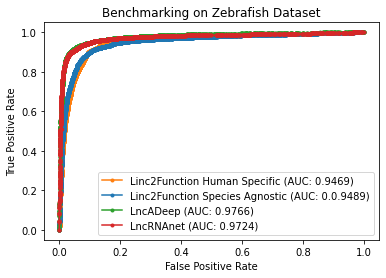

In [36]:

from sklearn.metrics import roc_curve
from matplotlib import pyplot

fpr_hs, tpr_hs, _ = roc_curve(y_hs_df, hs_preds)
fpr_sa, tpr_sa, _ = roc_curve(y_sa_df, sa_preds)
fpr_ld, tpr_ld, _ = roc_curve(lncadeep_results_df.TARGET, lncadeep_results_df.AverageScore)
fpr_lrn, tpr_lrn, _ = roc_curve(lncrnanet_results_df.TARGET, lncrnanet_results_df.Score)
pyplot.plot(fpr_hs, tpr_hs, marker='.', color='tab:orange', label='Linc2Function Human Specific (AUC: 0.9469)')
pyplot.plot(fpr_sa, tpr_sa, marker='.', color='tab:blue', label='Linc2Function Species Agnostic (AUC: 0.0.9489)')
pyplot.plot(fpr_ld, tpr_ld, marker='.', color='tab:green', label='LncADeep (AUC: 0.9766)')
pyplot.plot(fpr_lrn, tpr_lrn, marker='.', color='tab:red', label='LncRNAnet (AUC: 0.9724)')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.title('Benchmarking on Zebrafish Dataset')
pyplot.show()

# Wheat

## Linc2Function

In [37]:
import random 

coding_seq_list = []
noncoding_seq_list = []
hs_features_list = []
sa_features_list = []

for record in SeqIO.parse('data/Triticum_aestivum.IWGSC.cds.all.fa', "fasta"):
    sequence = str(record.seq)
    if 'N' not in sequence:
        coding_seq_list.append(sequence)

print('Coding sequences collected: ' + str(len(coding_seq_list)))
random.seed(123)
sampled_coding_seq_list = random.sample(coding_seq_list, 10000)

for sequence in sampled_coding_seq_list:
    hs_features = Identify.extractHSFeatures(sequence)
    hs_features.append(0)
    sa_features = Identify.extractSAFeatures(sequence)
    sa_features.append(0)
    hs_features_list.append(hs_features)
    sa_features_list.append(sa_features)

for record in SeqIO.parse('data/Triticum_aestivum.IWGSC.ncrna.fa', "fasta"):
    sequence = str(record.seq)
    if 'N' not in sequence:
        noncoding_seq_list.append(sequence)

print('Noncoding sequences collected: ' + str(len(noncoding_seq_list)))
random.seed(123)
sampled_noncoding_seq_list = random.sample(noncoding_seq_list, 10000)

for sequence in sampled_noncoding_seq_list:
    hs_features = Identify.extractHSFeatures(sequence)
    hs_features.append(1)
    sa_features = Identify.extractSAFeatures(sequence)
    sa_features.append(1)
    hs_features_list.append(hs_features)
    sa_features_list.append(sa_features)

Coding sequences collected: 132457
Noncoding sequences collected: 12526


In [38]:
hs_df = pd.DataFrame(hs_features_list, columns = hs_column_names)
sa_df = pd.DataFrame(sa_features_list, columns = sa_column_names)

In [39]:
X_hs_df = hs_df[hs_df.columns[~hs_df.columns.isin(['TARGET'])]]
y_hs_df = hs_df['TARGET']

X_sa_df = sa_df[sa_df.columns[~sa_df.columns.isin(['TARGET'])]]
y_sa_df = sa_df['TARGET']

In [40]:
hs_df_scaled = hs_scaler.transform(X_hs_df.astype(np.float64))
sa_df_scaled = sa_scaler.transform(X_sa_df.astype(np.float64))

In [41]:
hs_preds = hs_model.predict(hs_df_scaled)
sa_preds = sa_model.predict(sa_df_scaled)

hs_preds_classes = hs_model.predict_classes(hs_df_scaled)
sa_preds_classes = sa_model.predict_classes(sa_df_scaled)

## LncADeep

In [42]:
index = 0
results = []
with open('/home/monash/minor_thesis/workspace/LncADeep/wheat_noncoding_LncADeep_lncRNA_results/wheat_noncoding_LncADeep.results', 'r') as lncadeep_noncoding_results_file:
    while True:
        index += 1
        result = lncadeep_noncoding_results_file.readline()
        if index == 1:
            continue
        if not result:
            break
        results.append(result.strip().split('\t') + [1])
lncadeep_noncoding_results_df = pd.DataFrame(results, columns=['Transcript_ID', 'MajorityVoteNum', 'Index', '1_ModelScores', '2_ModelScores', '3_ModelScores', '4_ModelScores', '5_ModelScores', '6_ModelScores', '7_ModelScores', '8_ModelScores', '9_ModelScores', '10_ModelScores', '11_ModelScores', '12_ModelScores', '13_ModelScores', '14_ModelScores', '15_ModelScores', '16_ModelScores', '17_ModelScores', '18_ModelScores', '19_ModelScores', '20_ModelScores', '21_ModelScores', 'TARGET'])
lncadeep_noncoding_results_df.head()

Transcript_ID MajorityVoteNum      Index        1_ModelScores  \
0  ENSRNA050015569-T1               3  Noncoding  0.49369838001565175   
1  ENSRNA050021723-T1               0  Noncoding  0.07692865201704424   
2  ENSRNA050019452-T1              10  Noncoding   0.4718933679681735   
3  ENSRNA050021729-T1               0  Noncoding   0.3299346274757016   
4  ENSRNA050010761-T1              17     Coding   0.9436117042130113   

         2_ModelScores        3_ModelScores        4_ModelScores  \
0  0.07339105471659618  0.23140324676857765  0.29217653314733943   
1  0.02158951272640618  0.06896259038271739  0.03761345516695628   
2   0.9403725985959556   0.6530292434686309  0.23981929998065532   
3   0.1362422388110743   0.2201531606631051  0.09918970046302127   
4   0.8038006036304827   0.8235834334865706   0.5818055652581933   

         5_ModelScores         6_ModelScores         7_ModelScores  ...  \
0   0.1876785299879749   0.13895337832043206    0.2117612889552234  ...   
1  0.02113734509516621  0.025037394382870854  0.029001023312479144  ...   
2  0.34633070892102746      0.54469540091963   0.17480132464008302  ...   
3  0.12108836458091012   0.02123808832157107   0.16562781574740146  ...   
4   0.6084572613478557    0.8535858051533769    0.7264396589322611  ...   

         13_ModelScores       14_ModelScores        15_ModelScores  \
0  0.009885267035066295   0.3481071564439316   0.38297172648694794   
1  0.024370149613155034   0.0443660767657431  0.062275530468901004   
2   0.00805647683051333   0.3143698376935135     0.835925878817371   
3  0.005952494861731567  0.19729677111288396   0.07611941348397941   
4   0.03630878937339769   0.9366688772842285     0.600801287613234   

         16_ModelScores       17_ModelScores        18_ModelScores  \
0   0.15849879520943905   0.3015194541736671    0.2041708773862884   
1  0.030777304208108168  0.04958194777482025  0.025156812438367725   
2    0.5606375154876646   0.8220935697895101    0.7830363961253042   
3    0.0743484644123924  0.19218815528834088    0.1733442095171334   
4    0.3618418311752868   0.6032111891311099    0.8467558685801548   

        19_ModelScores        20_ModelScores        21_ModelScores TARGET  
0   0.5906363286909602    0.6211475640952434    0.3090868706449019      1  
1  0.13712769219420975  0.021466422444498583  0.044420087203791536      1  
2   0.7061819877864148   0.48021404299978543   0.11179922884178627      1  
3  0.04884529855486512  0.021971112191506784   0.10158125839706832      1  
4   0.8457993107250612    0.8205856423127621    0.6214411873264013      1  

[5 rows x 25 columns]

In [43]:
index = 0
results = []
with open('/home/monash/minor_thesis/workspace/LncADeep/wheat_coding_LncADeep_lncRNA_results/wheat_coding_LncADeep.results', 'r') as lncadeep_coding_results_file:
    while True:
        index += 1
        result = lncadeep_coding_results_file.readline()
        if index == 1:
            continue
        if not result:
            break
        results.append(result.strip().split('\t') + [0])
lncadeep_coding_results_df = pd.DataFrame(results, columns=['Transcript_ID', 'MajorityVoteNum', 'Index', '1_ModelScores', '2_ModelScores', '3_ModelScores', '4_ModelScores', '5_ModelScores', '6_ModelScores', '7_ModelScores', '8_ModelScores', '9_ModelScores', '10_ModelScores', '11_ModelScores', '12_ModelScores', '13_ModelScores', '14_ModelScores', '15_ModelScores', '16_ModelScores', '17_ModelScores', '18_ModelScores', '19_ModelScores', '20_ModelScores', '21_ModelScores', 'TARGET'])
lncadeep_coding_results_df.head()

Transcript_ID MajorityVoteNum   Index       1_ModelScores  \
0  TraesCS5D02G501000.1              21  Coding  0.9912293482255632   
1  TraesCS5D02G238000.1              21  Coding   0.995429742159254   
2  TraesCS7D02G026900.1              21  Coding   0.984307642961914   
3  TraesCS2D02G300500.1              21  Coding  0.9957177256446619   
4  TraesCS4B02G033000.1              21  Coding   0.963871141911409   

        2_ModelScores       3_ModelScores       4_ModelScores  \
0  0.9844232916248271  0.9914926246524017  0.9889953759844112   
1  0.9981031255178429  0.9964508976386145   0.995594232968864   
2  0.9931292588671393  0.9931886927756939  0.9760311616759287   
3  0.9975892768020047  0.9965845187897039  0.9931025487280378   
4  0.9959595345043897  0.9736807742889712  0.9581461056316192   

        5_ModelScores       6_ModelScores       7_ModelScores  ...  \
0  0.9741280409730653   0.989379499252862  0.9978328147153188  ...   
1  0.9948855745521755  0.9942341317018075  0.9920910548288351  ...   
2  0.9490111689537574  0.9928599172284062  0.9699011743670306  ...   
3  0.9857684091204236  0.9927772255258676  0.9956231636861473  ...   
4  0.8732742638583065  0.9856906387634126  0.9967678309080912  ...   

       13_ModelScores      14_ModelScores      15_ModelScores  \
0  0.9904174452856199  0.9891434751389373  0.9863728260603194   
1  0.9970791543088082  0.9975335183712579   0.997509770973924   
2  0.9648217051443873  0.9775355174081894  0.9843269904708616   
3  0.9958123202208511  0.9942182543764102  0.9967512616677775   
4  0.9785802884765707  0.9723468509377452   0.945671119211797   

       16_ModelScores      17_ModelScores      18_ModelScores  \
0  0.9711038687800106   0.986483657284299  0.9962600105697685   
1  0.9971787649416645  0.9971928835428786  0.9980734455970061   
2  0.9863894042033912  0.9688626963352647  0.9719866196736207   
3  0.9930590999152591  0.9968184655670773  0.9956881454842667   
4  0.9548091151895257  0.9886456775048523  0.9864907054922413   

       19_ModelScores      20_ModelScores      21_ModelScores TARGET  
0   0.993661974582756  0.9863972773642266  0.9909935196950872      0  
1  0.9950373664469733  0.9967201208570183  0.9973472472731622      0  
2  0.9893623005455072  0.9819636329027688  0.9943217269532802      0  
3  0.9978162529371106  0.9946872365922429  0.9951029320337074      0  
4  0.9865904716426912  0.9842212541706296  0.9895177510401998      0  

[5 rows x 25 columns]

In [44]:
lncadeep_results_df = pd.concat([lncadeep_noncoding_results_df, lncadeep_coding_results_df])
lncadeep_results_df.shape

(20000, 25)

In [45]:
for column in lncadeep_results_df.columns:
    if column.endswith('ModelScores'):
        lncadeep_results_df[column] = lncadeep_results_df[column].astype(float)

lncadeep_results_df['Index'] = [1 if value == 'Noncoding' else 0 for value in lncadeep_results_df['Index']]

lncadeep_results_df['AverageScore'] = lncadeep_results_df[['1_ModelScores', '2_ModelScores', '3_ModelScores', '4_ModelScores', '5_ModelScores', '6_ModelScores', '7_ModelScores', '8_ModelScores', '9_ModelScores', '10_ModelScores', '11_ModelScores', '12_ModelScores', '13_ModelScores', '14_ModelScores', '15_ModelScores', '16_ModelScores', '17_ModelScores', '18_ModelScores', '19_ModelScores', '20_ModelScores', '21_ModelScores']].mean(axis=1)

lncadeep_results_df['AverageScore'] = [1 - value for value in lncadeep_results_df['AverageScore']]

lncadeep_results_df.head()

Transcript_ID MajorityVoteNum  Index  1_ModelScores  2_ModelScores  \
0  ENSRNA050015569-T1               3      1       0.493698       0.073391   
1  ENSRNA050021723-T1               0      1       0.076929       0.021590   
2  ENSRNA050019452-T1              10      1       0.471893       0.940373   
3  ENSRNA050021729-T1               0      1       0.329935       0.136242   
4  ENSRNA050010761-T1              17      0       0.943612       0.803801   

   3_ModelScores  4_ModelScores  5_ModelScores  6_ModelScores  7_ModelScores  \
0       0.231403       0.292177       0.187679       0.138953       0.211761   
1       0.068963       0.037613       0.021137       0.025037       0.029001   
2       0.653029       0.239819       0.346331       0.544695       0.174801   
3       0.220153       0.099190       0.121088       0.021238       0.165628   
4       0.823583       0.581806       0.608457       0.853586       0.726440   

   ...  14_ModelScores  15_ModelScores  16_ModelScores  17_ModelScores  \
0  ...        0.348107        0.382972        0.158499        0.301519   
1  ...        0.044366        0.062276        0.030777        0.049582   
2  ...        0.314370        0.835926        0.560638        0.822094   
3  ...        0.197297        0.076119        0.074348        0.192188   
4  ...        0.936669        0.600801        0.361842        0.603211   

   18_ModelScores  19_ModelScores  20_ModelScores  21_ModelScores  TARGET  \
0        0.204171        0.590636        0.621148        0.309087       1   
1        0.025157        0.137128        0.021466        0.044420       1   
2        0.783036        0.706182        0.480214        0.111799       1   
3        0.173344        0.048845        0.021971        0.101581       1   
4        0.846756        0.845799        0.820586        0.621441       1   

   AverageScore  
0      0.738504  
1      0.961438  
2      0.537277  
3      0.878644  
4      0.332931  

[5 rows x 26 columns]

## LncRNAnet

In [46]:
lncrnanet_coding_results_df = pd.read_csv('/home/monash/minor_thesis/workspace/lncRNAnet/data/benchmark/benchmark_wheat_coding.txt', sep='\t', header=None)
lncrnanet_coding_results_df.columns = ['TranscriptId', 'TranscriptLength', 'Score']
lncrnanet_coding_results_df['TARGET'] = [0] * lncrnanet_coding_results_df.shape[0]
lncrnanet_coding_results_df['PREDICTION'] = [0 if score < 0 else 1 for score in lncrnanet_coding_results_df.Score]
lncrnanet_coding_results_df.head()

TranscriptId  TranscriptLength     Score  TARGET  PREDICTION
0  TraesCS5D02G501000.1              1440 -0.999804       0           0
1  TraesCS5D02G238000.1               912 -0.999525       0           0
2  TraesCS7D02G026900.1              1014 -0.999811       0           0
3  TraesCS2D02G300500.1               810 -0.999559       0           0
4  TraesCS4B02G033000.1              1515 -0.999522       0           0

In [47]:
lncrnanet_noncoding_results_df = pd.read_csv('/home/monash/minor_thesis/workspace/lncRNAnet/data/benchmark/benchmark_wheat_noncoding.txt', sep='\t', header=None)
lncrnanet_noncoding_results_df.columns = ['TranscriptId', 'TranscriptLength', 'Score']
lncrnanet_noncoding_results_df['TARGET'] = [1] * lncrnanet_noncoding_results_df.shape[0]
lncrnanet_noncoding_results_df['PREDICTION'] = [0 if score < 0 else 1 for score in lncrnanet_noncoding_results_df.Score]
lncrnanet_noncoding_results_df.head()

TranscriptId  TranscriptLength     Score  TARGET  PREDICTION
0  ENSRNA050015569-T1               119  0.870692       1           1
1  ENSRNA050021723-T1               466  0.341649       1           1
2  ENSRNA050019452-T1                95 -0.461899       1           0
3  ENSRNA050021729-T1                97  0.521398       1           1
4  ENSRNA050010761-T1                72  0.993781       1           1

In [48]:
lncrnanet_results_df = pd.concat([lncrnanet_noncoding_results_df, lncrnanet_coding_results_df])
lncrnanet_results_df.shape

(20000, 5)

## Results

In [49]:
from sklearn.metrics import auc, accuracy_score, accuracy_score, balanced_accuracy_score

fpr_hs, tpr_hs, _ = roc_curve(y_hs_df, hs_preds)
fpr_sa, tpr_sa, _ = roc_curve(y_sa_df, sa_preds)
fpr_ld, tpr_ld, _ = roc_curve(lncadeep_results_df.TARGET, lncadeep_results_df.AverageScore)
fpr_lrn, tpr_lrn, _ = roc_curve(lncrnanet_results_df.TARGET, lncrnanet_results_df.Score)
auc_hs = auc(fpr_hs, tpr_hs)
auc_sa = auc(fpr_sa, tpr_sa)
auc_ld = auc(fpr_ld, tpr_ld)
auc_lrn = auc(fpr_lrn, tpr_lrn)
accuracy_score_hs = accuracy_score(y_hs_df, hs_preds_classes)
accuracy_score_sa = accuracy_score(y_sa_df, sa_preds_classes)
accuracy_score_ld = accuracy_score(lncadeep_results_df.TARGET, lncadeep_results_df.Index)
accuracy_score_lrn = accuracy_score(lncrnanet_results_df.TARGET, lncrnanet_results_df.PREDICTION)
balanced_accuracy_score_hs = balanced_accuracy_score(y_hs_df, hs_preds_classes)
balanced_accuracy_score_sa = balanced_accuracy_score(y_sa_df, sa_preds_classes)
balanced_accuracy_score_ld = balanced_accuracy_score(lncadeep_results_df.TARGET, lncadeep_results_df.Index)
balanced_accuracy_score_lrn = balanced_accuracy_score(lncrnanet_results_df.TARGET, lncrnanet_results_df.PREDICTION)
print("AUC for Linc2Function Human Specific Model: ", auc_hs)
print("AUC for Linc2Function Species Agnostic Model: ", auc_sa)
print("AUC for LncADeep Model: ", auc_ld)
print("AUC for LncRNAnet Model: ", auc_lrn)
print("Accuracy Score for Linc2Function Human Specific Model: ", accuracy_score_hs)
print("Accuracy Score for Linc2Function Species Agnostic Model: ", accuracy_score_sa)
print("Accuracy Score for LncADeep Model: ", accuracy_score_ld)
print("Accuracy Score for LncRNAnet Model: ", accuracy_score_lrn)
print("Balanced Accuracy Score for Linc2Function Human Specific Model: ", balanced_accuracy_score_hs)
print("Balanced Accuracy Score for Linc2Function Species Agnostic Model: ", balanced_accuracy_score_sa)
print("Balanced Accuracy Score for LncADeep Model: ", balanced_accuracy_score_ld)
print("Balanced Accuracy Score for LncRNAnet Model: ", balanced_accuracy_score_lrn)


AUC for Linc2Function Human Specific Model:  0.98965776
AUC for Linc2Function Species Agnostic Model:  0.99433124
AUC for LncADeep Model:  0.98226999
AUC for LncRNAnet Model:  0.9968797300000001
Accuracy Score for Linc2Function Human Specific Model:  0.76185
Accuracy Score for Linc2Function Species Agnostic Model:  0.9505
Accuracy Score for LncADeep Model:  0.90725
Accuracy Score for LncRNAnet Model:  0.97495
Balanced Accuracy Score for Linc2Function Human Specific Model:  0.7618499999999999
Balanced Accuracy Score for Linc2Function Species Agnostic Model:  0.9505
Balanced Accuracy Score for LncADeep Model:  0.90725
Balanced Accuracy Score for LncRNAnet Model:  0.97495


In [50]:
from sklearn.metrics import classification_report
target_names = ['coding', 'noncoding']
print('Classification Report for Linc2Function Human Specific Model: ')
print(classification_report(y_hs_df, hs_preds_classes, target_names=target_names))
print('Classification Report for Linc2Function Species Agnostic Model: ')
print(classification_report(y_sa_df, sa_preds_classes, target_names=target_names))
print('Classification Report for LncADeep Model: ')
print(classification_report(lncadeep_results_df.TARGET, lncadeep_results_df.Index, target_names=target_names))
print('Classification Report for LncRNAnet Model: ')
print(classification_report(lncrnanet_results_df.TARGET, lncrnanet_results_df.PREDICTION, target_names=target_names))

Classification Report for Linc2Function Human Specific Model: 
              precision    recall  f1-score   support

      coding       0.68      0.99      0.81     10000
   noncoding       0.98      0.53      0.69     10000

    accuracy                           0.76     20000
   macro avg       0.83      0.76      0.75     20000
weighted avg       0.83      0.76      0.75     20000

Classification Report for Linc2Function Species Agnostic Model: 
              precision    recall  f1-score   support

      coding       0.92      0.99      0.95     10000
   noncoding       0.99      0.91      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Classification Report for LncADeep Model: 
              precision    recall  f1-score   support

      coding       0.86      0.97      0.91     10000
   noncoding       0.96      0.85      0.90     10000

    accurac

In [51]:
from sklearn.metrics import confusion_matrix

print('Confusion Matrix for Linc2Function Human Specific Model: ')
confusion_matrix_hs = confusion_matrix(y_hs_df, hs_preds_classes)
print(confusion_matrix_hs)
print('Confusion Matrix for Linc2Function Species Agnostic Model: ')
confusion_matrix_sa = confusion_matrix(y_sa_df, sa_preds_classes)
print(confusion_matrix_sa)
print('Confusion Matrix for LncADeep Model: ')
confusion_matrix_ld = confusion_matrix(lncadeep_results_df.TARGET, lncadeep_results_df.Index)
print(confusion_matrix_ld)
print('Confusion Matrix for LncRNAnet Model: ')
confusion_matrix_lrn = confusion_matrix(lncrnanet_results_df.TARGET, lncrnanet_results_df.PREDICTION)
print(confusion_matrix_lrn)

Confusion Matrix for Linc2Function Human Specific Model: 
[[9903   97]
 [4666 5334]]
Confusion Matrix for Linc2Function Species Agnostic Model: 
[[9885  115]
 [ 875 9125]]
Confusion Matrix for LncADeep Model: 
[[9654  346]
 [1509 8491]]
Confusion Matrix for LncRNAnet Model: 
[[9870  130]
 [ 371 9629]]


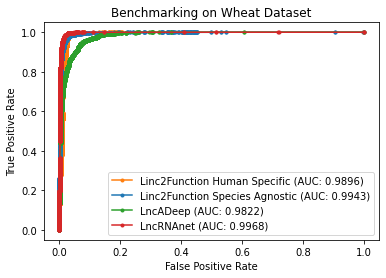

In [52]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot

fpr_hs, tpr_hs, _ = roc_curve(y_hs_df, hs_preds)
fpr_sa, tpr_sa, _ = roc_curve(y_sa_df, sa_preds)
fpr_ld, tpr_ld, _ = roc_curve(lncadeep_results_df.TARGET, lncadeep_results_df.AverageScore)
fpr_lrn, tpr_lrn, _ = roc_curve(lncrnanet_results_df.TARGET, lncrnanet_results_df.Score)
pyplot.plot(fpr_hs, tpr_hs, marker='.', color='tab:orange', label='Linc2Function Human Specific (AUC: 0.9896)')
pyplot.plot(fpr_sa, tpr_sa, marker='.', color='tab:blue', label='Linc2Function Species Agnostic (AUC: 0.9943)')
pyplot.plot(fpr_ld, tpr_ld, marker='.', color='tab:green', label='LncADeep (AUC: 0.9822)')
pyplot.plot(fpr_lrn, tpr_lrn, marker='.', color='tab:red', label='LncRNAnet (AUC: 0.9968)')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.title('Benchmarking on Wheat Dataset')
pyplot.show()